In [1]:
# Insert code here.
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float
import torch.nn as nn
import math

%matplotlib inline


In [2]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

0
1
NVIDIA TITAN Xp COLLECTORS EDITION
True


In [3]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [4]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    gopts = torch.ones(x.shape, dtype=dtype, device = torch.device('cuda:0'))
    return grad([f], [x], grad_outputs=gopts, create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
    # stochastic perturbation of the evaluation points
    # force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [5]:
def parametricSolutions(t, nn, t0, x1):
    N1,N2 = nn(t)
    dt =t-t0
    f = (1-torch.exp(-dt))*(1-torch.exp(dt-12))
    psi_hat  = x1  + f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E,V):

    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx/2 + (E-V)*psi
    L  = (f.pow(2)).mean(); 
    H_psi = -1*psi_ddx/2 + (V)*psi
    return L, f, H_psi

In [6]:
class qNN1_notskip(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1_notskip,self).__init__()

        # Define the Activation
        #  self.actF = torch.nn.Sigmoid()   
        self.sym = True
        self.actF = mySin()
        
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.out    = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))

        L1 = self.Lin_1(torch.cat((t,In1),1))
        L1p = self.Lin_1(torch.cat((-1*t,In1),1))

        h1 = self.actF(L1)
        h1p = self.actF(L1p)
        
        L2 = self.Lin_2(h1)
        L2p = self.Lin_2(h1p)

        h2 = self.actF(L2)
        h2p = self.actF(L2p)
        
        if self.sym:
          out = self.out(h2+h2p)
        else:
          out = self.out(h2-h2p)
        return out, In1

class qNN1(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1,self).__init__()

        # Define the Activation
        #  self.actF = torch.nn.Sigmoid()   
        self.actF = mySin()
        
        # define layers
        #self.Lin_1   = torch.nn.Linear(1, D_hid)
        #self.E_out = torch.nn.Linear(D_hid, 1)
        #self.Lin_2 = torch.nn.Linear(D_hid, D_hid)
        #self.Ein = torch.nn.Linear(1,1)
        #self.Lin_out = torch.nn.Linear(D_hid+1, 1)
        self.sym = True
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid+1, D_hid)
        self.out    = torch.nn.Linear(D_hid+1, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))

        L1 = self.Lin_1(torch.cat((t,In1),1))
        L1p = self.Lin_1(torch.cat((-1*t,In1),1))

        h1 = self.actF(L1)
        h1p = self.actF(L1p)
        
        L2 = self.Lin_2(torch.cat((h1,In1),1))
        L2p = self.Lin_2(torch.cat((h1p,In1),1))

        h2 = self.actF(L2)
        h2p = self.actF(L2p)

        #out = self.out(torch.cat((h2+h2p,In1),1))
        #out = self.out(torch.cat((h2,In1),1))

        if self.sym:
          out = self.out(torch.cat((h2+h2p,In1),1))
        else:
          out = self.out(torch.cat((h2-h2p,In1),1))

        return out, In1

In [7]:
def potential(Xs):
  # Gives the potential at each point
  # Takes in tensor of x points, gives back tensor of V at each point
  L = 1

  Xsnp = Xs.data.numpy()
  Vnp = (np.heaviside(-1*Xsnp-1.7, 0) + np.heaviside(Xsnp-1.7, 0))*20

  Vtorch = torch.from_numpy(Vnp)
  return Vtorch



Text(0, 0.5, 'V')

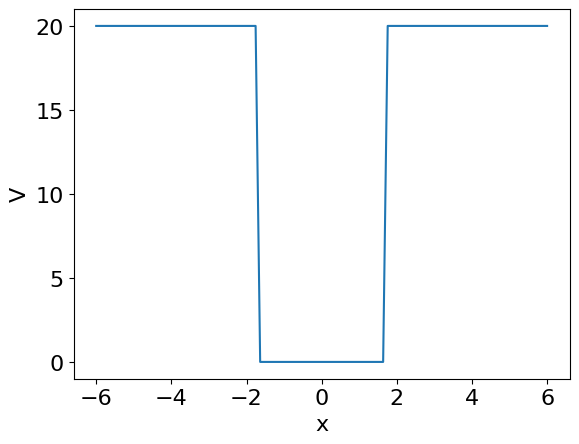

In [8]:
plotxs = np.linspace(-6,6,100)
L = 1
plotys = potential(torch.tensor(plotxs))
plt.plot(plotxs, plotys)
plt.xlabel('x')
plt.ylabel('V')

In [9]:
def weights_init(m):
  if isinstance(m, nn.Linear) and m.weight.shape[0] != 1:
    torch.nn.init.xavier_uniform(m.weight.data)

In [10]:
# Train the NN
def run_Scan_finitewell(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    par2 = 0
    fc0 = qNN1(neurons)
    fc0.cuda()
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    prob_loss = []
    EWall_history = []
    orth_losses = []
    di = (None, 1e+20)
    dic = {}
    for i in range(50):
      dic[i] = di
    orth_counter = 0
    swith = False
    internal_SE_loss = []

    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -1.5
    last_psi_L = 0
    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
# Perturbing the evaluation points & forcing t[0]=t0
        t=perturbPoints(grid,t0,tf,sig=.03*tf)
            
# BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0


        for nbatch in range(minibatch_number): 
# batch time set
            t_mb = t_b[batch_start:batch_end].cuda()
            

#  Network solutions 
            nn, En = fc0(t_mb)
            En = torch.abs(En) #  + np.random.normal(0,1,1)[0]*torch.ones_like(En)/30

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1).cuda()
            Pot = potential(t_mb.cpu())
            Ltot, f_ret, H_psi = hamEqs_Loss(t_mb, psi, En.cuda(), Pot.cuda())
            #Ltot /= En.detach()[0].data.tolist()[0]**2
            SE_loss_history.append(Ltot) #
            internal_SE_loss.append(Ltot.cpu().detach().numpy())
            criteria_loss = Ltot

            
            Ltot += ((n_train/(tf-t0))*1.0-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2)

            

            window = 1000
            if len(internal_SE_loss) >= window+1:
              rm = np.mean(np.array(internal_SE_loss[-window:])-np.array(internal_SE_loss[-window-1:-1]))
            else:
              rm = np.mean(np.array(internal_SE_loss[1:])-np.array(internal_SE_loss[:-1]))
            
            if tt % 300 == 0:
              print('Epoch', tt)
              print('E', En_history[-1])
              print('rm', rm)
              print('oc', orth_counter)

            exp_thresh = -14
            if tt == 1.5e4:
              fc0.apply(weights_init)
              orth_counter += 1
              print('Epoch', tt)
              print('E', En_history[-1])
              print('rm', rm)
              print('oc', orth_counter)
            elif rm < np.exp(exp_thresh) and rm > 0 and orth_counter == 1:
              fc0.apply(weights_init)
              orth_counter += 1
              print('Epoch', tt)
              print('E', En_history[-1])
              print('rm', rm)
              print('oc', orth_counter)
            elif rm < np.exp(exp_thresh) and rm > 0 and orth_counter == 2:
              fc0.sym = False
              orth_counter += 1
              print('Epoch', tt)
              print('E', En_history[-1])
              print('rm', rm)
              print('oc', orth_counter)
            elif rm < np.exp(exp_thresh) and rm > 0 and orth_counter == 3:
              orth_counter += 1
              print('Epoch', tt)
              print('E', En_history[-1])
              print('rm', rm)
              print('oc', orth_counter)

            if orth_counter == 1:
              par2 = parametricSolutions(t_mb, dic[0][0], t0, x1)
              ortho_loss = torch.sqrt(torch.dot(par2[:,0], psi[:,0]).pow(2))/25
              orth_losses.append(ortho_loss)
              Ltot += ortho_loss  
            elif orth_counter == 2 or orth_counter == 3:
                
              par2 = parametricSolutions(t_mb, dic[0][0], t0, x1)
              par3 = parametricSolutions(t_mb, dic[3][0], t0, x1)
              ortho_loss = torch.sqrt(torch.dot(par2[:,0]+par3[:,0], psi[:,0]).pow(2))/25 # get rid of sqrt
              orth_losses.append(ortho_loss)
              Ltot += ortho_loss
            elif orth_counter == 4:
              #if tt == 8e4:
              #  fc0.sym = True

              par2 = parametricSolutions(t_mb, dic[0][0], t0, x1)
              par3 = parametricSolutions(t_mb, dic[3][0], t0, x1)
              par4 = parametricSolutions(t_mb, dic[1][0], t0, x1)
              ortho_loss = torch.sqrt(torch.dot(par2[:,0]+par3[:,0]+par4[:,0], psi[:,0]).pow(2))/25 # get rid of sqrt
              orth_losses.append(ortho_loss)
              Ltot += ortho_loss
              

            #if (tt > 1e4 and tt < 3e4):
            #  torth = t.cuda()
            #  psi2 = parametricSolutions(torth, fc0, t0, x1).cuda()
            #  par2 = parametricSolutions(torth, dic[3][0], t0, x1)
            #  ortho_loss = torch.sqrt(torch.dot(par2[400:800,0], psi2[400:800,0]).pow(2))/100
            #  orth_losses.append(ortho_loss)
            #  Ltot += ortho_loss
            #elif (tt >= 3e4):
            #  par2 = parametricSolutions(t_mb, dic[1][0], t0, x1)
            #  par3 = parametricSolutions(t_mb, dic[3][0], t0, x1)
            #  ortho_loss = torch.sqrt(torch.dot(par3[:,0], psi[:,0]).pow(2))/10 + torch.sqrt(torch.dot(par2[:,0], psi[:,0]).pow(2))/10
            #  orth_losses.append(ortho_loss)
            #  Ltot += ortho_loss              

            En_loss_history.append(torch.exp(-1*En+walle).mean()) #
            EWall_history.append(walle)
            
            #nontriv_loss_history.append(1/((psi.pow(2)).mean()+1e-6)) #
            nontriv_loss_history.append( ((n_train/(tf-t0))*1.0-torch.sqrt(torch.dot(psi[:,0],psi[:,0]))).pow(2))
            #Ennontriv_loss_history.append(1/(En.pow(2).mean()+1e-6)) #
            Ennontriv_loss_history.append(1/En[0][0].pow(2))
# OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.cpu().data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

# keep the loss function history
        Loss_history.append(loss)       

#Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss

        E_bin = abs(En[0].data.tolist()[0])//1  
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss, (t_mb, f_ret, H_psi, psi))

        

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic, orth_losses)
    return fc1, loss_histories, runTime, fc0

In [11]:
## Train the model 

t0 = -6.
tf = 6.
xBC1=0.

n_train, neurons, epochs, lr,mb = 1200, 100, int(7e4), 1e-2, 1 
model1,loss_hists1,runTime1, latest_model = run_Scan_finitewell(t0, tf, xBC1, neurons, epochs, n_train, lr, mb)

/home/bornexmachina/.venvs/deltapinns/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bornexmachina/.venvs/deltapinns/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 0
E 0.757038950920105
rm nan
oc 0
Epoch 300
E 0.07465817034244537
rm 0.12408493
oc 0
Epoch 600
E 0.04624997079372406
rm 0.026455628
oc 0
Epoch 900
E 0.11564536392688751
rm 0.006207354
oc 0
Epoch 1200
E 0.1195688247680664
rm -0.014066862
oc 0
Epoch 1500
E 0.1291995346546173
rm -0.01840847
oc 0
Epoch 1800
E 0.1493256390094757
rm -0.007102994
oc 0
Epoch 2100
E 0.1662999838590622
rm -0.0011920943
oc 0
Epoch 2400
E 0.19794730842113495
rm -0.0021703169
oc 0
Epoch 2700
E 0.23223154246807098
rm -0.0013413561
oc 0
Epoch 3000
E 0.25739145278930664
rm -0.0018688473
oc 0
Epoch 3300
E 0.27617841958999634
rm -0.00090729556
oc 0
Epoch 3600
E 0.29220670461654663
rm -0.00042693544
oc 0
Epoch 3900
E 0.3120003044605255
rm -0.00049775245
oc 0
Epoch 4200
E 0.3294636011123657
rm -0.00045771943
oc 0
Epoch 4500
E 0.34298262000083923
rm -0.00035308217
oc 0
Epoch 4800
E 0.352787584066391
rm -0.00027549648
oc 0
Epoch 5100
E 0.3590908646583557
rm -0.00023037053
oc 0
Epoch 5400
E 0.3670133352279663
rm -0.000

/tmp/ipykernel_269736/532615994.py:3: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight.data)


Epoch 15300
E 0.31423288583755493
rm 0.1939843
oc 1
Epoch 15600
E 0.28510844707489014
rm 0.12608948
oc 1
Epoch 15900
E 0.41680100560188293
rm 0.09727174
oc 1
Epoch 16200
E 0.6040897369384766
rm -0.10306437
oc 1
Epoch 16500
E 0.9855362176895142
rm -0.08292068
oc 1
Epoch 16800
E 1.4437403678894043
rm -0.06808115
oc 1
Epoch 17100
E 1.9282872676849365
rm -0.06194223
oc 1
Epoch 17400
E 2.4019031524658203
rm -0.047511466
oc 1
Epoch 17700
E 2.831434726715088
rm -0.03324988
oc 1
Epoch 18000
E 3.1742007732391357
rm -0.026343247
oc 1
Epoch 18300
E 3.398075580596924
rm -0.016757753
oc 1
Epoch 18600
E 3.4895811080932617
rm -0.009255988
oc 1
Epoch 18900
E 3.5126967430114746
rm -0.001403121
oc 1
Epoch 19200
E 3.480963706970215
rm -0.0038328066
oc 1
Epoch 19500
E 3.403550624847412
rm -0.00086254405
oc 1
Epoch 19800
E 3.2923216819763184
rm -0.002174839
oc 1
Epoch 20100
E 3.1968164443969727
rm -0.0010780134
oc 1
Epoch 20400
E 3.118419647216797
rm -0.0011327353
oc 1
Epoch 20700
E 3.0807085037231445
rm -

Training time (minutes): 13.960416253407796


Text(0.5, 25.52222222222221, 'Epochs')

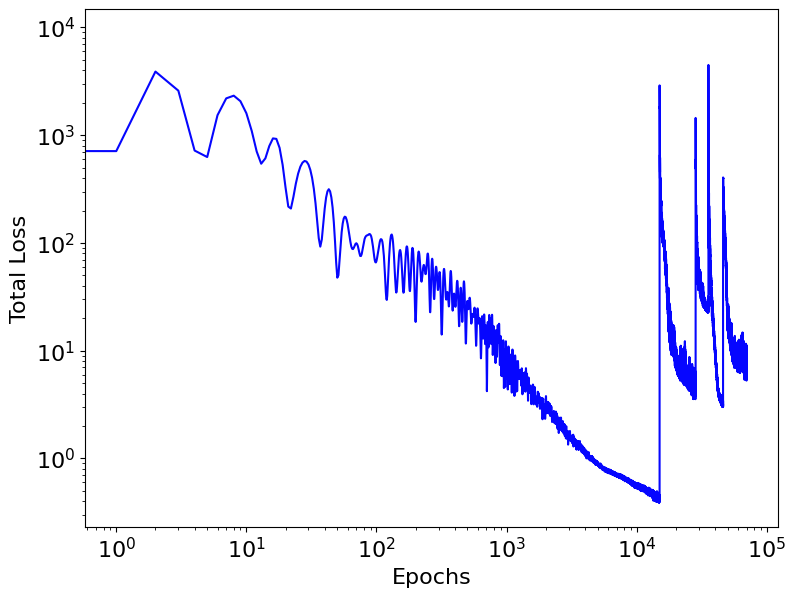

In [12]:
# Loss function
print('Training time (minutes):', runTime1/60)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_total_loss.png', bbox_inches = 'tight')

# Symm, square rooting both terms in normalisation loss term

# Eigenvalue. +1

In [ ]:
# TEST THE PREDICTED SOLUTIONS
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,model1.cpu(),t0,xBC1) 
psi=psi.data.numpy(); 

In [ ]:
tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
plt.xlim(-6,6)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')

plotxs = np.linspace(-6,6,100)
L = 2
plotys = 10*(np.heaviside(plotxs+4/8, 0) + np.heaviside(-1*plotxs+4/8, 0) + np.heaviside(plotxs-20/8, 0) + np.heaviside(-1*plotxs-20/8, 0))-10
plt.plot(plotxs, plotys, '-r')



In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
se_loss_cpu = [loss.cpu().detach().numpy() if torch.is_tensor(loss) else loss 
               for loss in loss_hists1[3]]
plt.figure(figsize =(8,6))

plt.loglog(se_loss_cpu,'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_SE_loss.png', bbox_inches = 'tight')

In [ ]:
SE_loss_delta = np.array(loss_hists1[3])[1:]-np.array(loss_hists1[3])[:-1]

#plt.loglog(np.convolve(SE_loss_delta, np.ones(50))/50,'-b',alpha=0.975);




In [ ]:
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[11],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Ortho Loss');plt.xlabel('Epochs')

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[2],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Normalisation to 100 Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_nextE_loss.png', bbox_inches = 'tight')

In [ ]:
# Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history
plt.figure(figsize =(8,6))


plt.semilogy([0]*(40000-20000)+loss_hists1[11],'-b',alpha=0.975, label = 'Ortho Loss');
plt.semilogy(loss_hists1[2],'-r',alpha=0.975, label = 'Norm Loss');
plt.semilogy(loss_hists1[3],'--c',alpha=0.975, label = 'Schrod. Eq.');
#plt.semilogy(loss_hists1[9],'-k',alpha=0.975, label = 'Schrod. Eq.');

#plt.semilogy(loss_hists1[])

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Losses'); plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_all_loss.png', bbox_inches = 'tight')

Text(0.5, 30.722222222222207, 'Epochs')

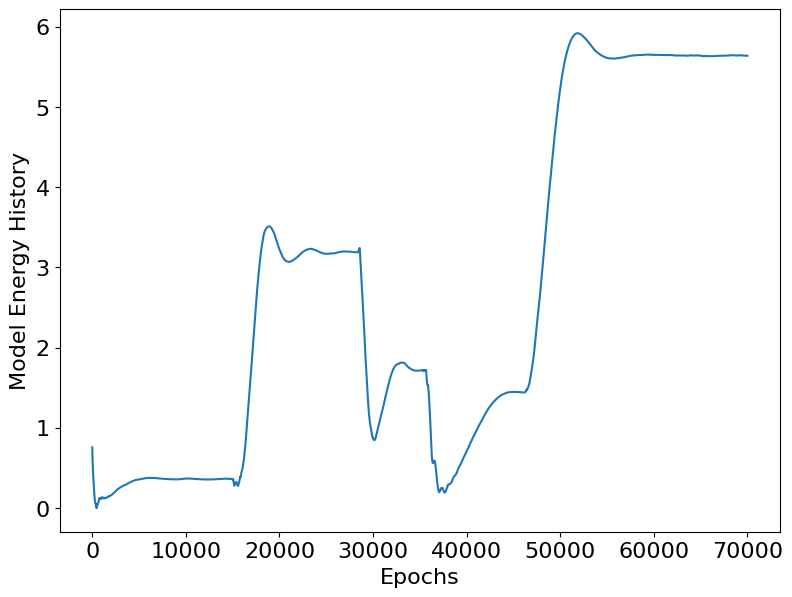

In [13]:
energy_loss_cpu = [loss.cpu().detach().numpy() if torch.is_tensor(loss) else loss 
               for loss in loss_hists1[8]]
plt.figure(figsize = (8,6))
plt.plot(energy_loss_cpu)
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_modelE_hist.png', bbox_inches = 'tight')

#+2

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(loss_hists1[8])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History')#;plt.xlabel('Epochs')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#plt.savefig(imgdir+'finite_single_plateaus_E.png', bbox_inches = 'tight')

plt.figure(figsize =(8,4))

plt.plot(np.log10(np.asarray(se_loss_cpu)),'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_single_plateaus_SE.png', bbox_inches = 'tight')

#/50 for first orth and /200 for second

In [ ]:
bin = 0
a = loss_hists1[10][bin][2][0].cpu().detach().numpy()
b = loss_hists1[10][bin][2][1].cpu().detach().numpy()
zz = zip(a, b)
zz = np.asarray(sorted(zz))
print(zz.shape)
plt.plot(zz[:,0,:], zz[:,1,:])

In [ ]:
bin = 3
psi_0to10 = parametricSolutions(tTest,loss_hists1[10][bin][0].cpu(),t0,xBC1)


plt.figure(figsize = (8,6))
plt.plot(t_net, 1*psi_0to10.data.numpy(), '-b', linewidth=1, label = 'n = 1')

plotxs = np.linspace(-6,6,100)
L = 1
plotys = (np.heaviside(plotxs+0.6, 0) + np.heaviside(-1*plotxs+0.6, 0) + np.heaviside(plotxs-1.6, 0) + np.heaviside(-1*plotxs-1.6, 0) + np.heaviside(1*plotxs-0.5, 0) + np.heaviside(-1*plotxs-0.5, 0)) -2


plt.ylabel('$\psi(x)$'); plt.xlabel('x')
#plt.savefig(imgdir+'finite_single_eigenfuncs3.png', bbox_inches = 'tight')


In [ ]:
psi_dirac_x = loss_hists1[10][bin][2][0]
psi_dirac_H = loss_hists1[10][bin][2][2]
psi_dirac = loss_hists1[10][bin][2][3]
#psiHpsi_over_psipsi = np.trapz()
psi_dirac_x



In [ ]:
sorted_index = torch.argsort(psi_dirac_x, dim = 0)
sorted_x = psi_dirac_x[sorted_index][:,0,0]
sorted_psi = psi_dirac[sorted_index][:,0,0]
sorted_H = psi_dirac_H[sorted_index][:,0,0]
#psi_psi = np.trapz(sorted_psi**2, sorted_x)
#sort_norm_psi = sorted_psi/(psi_psi**(1/2))
pHp_pp = np.trapz(np.multiply(sorted_H.cpu().data.numpy(),sorted_psi.cpu().data.numpy()), sorted_x.cpu().data.numpy())/np.trapz(sorted_psi.cpu().data.numpy()**2, sorted_x.cpu().data.numpy())
pHp_pp


In [ ]:
#parametricSolutions2(tTest.cuda(), t0, xBC1).cpu().detach().numpy().shape
#psi_0to10.detach().numpy()
np.dot(parametricSolutions2(tTest.cuda(), t0, xBC1).cpu().detach().numpy().reshape(1,-1), psi_0to10.detach().numpy())

In [ ]:
import pickle

with open(imgdir+'fin_square_single_patience.pickle', 'wb') as handle:
    pickle.dump(loss_hists1, handle)

# Numerical Solutions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.optimize as opt
# Setup the input values
hbar=1
m=1

for a in [1.,2.]:
    z0 = 4*np.pi /2
    V0 = 10 # (z0*hbar/a)**2 /m/2
    z0 = a/hbar * np.sqrt(2*m*V0)
    # V0 = 2*(np.pi*hbar/a)**2 /m/8 

    epsilon = 0.0001 # Sufficiently small but not zero to avoid devide by zero issues.
    # Setup the two equations that need to be solved. 
    def opt_fun1(z,z0):
        return( np.tan(z) - np.sqrt((z0/z)**2 -1 ))
    def opt_fun2(z,z0):
        return( -1/np.tan(z) - np.sqrt((z0/z)**2 -1 ))

    result = []
    z = []
    Ex = []
    for i in range(2*int(z0/np.pi)+1):
        if i*np.pi/2 < z0:
            if (i%2 == 0):
                result.append(opt.root_scalar(opt_fun1,z0,bracket=[np.pi*i/2+epsilon,min((i+1)*np.pi/2-epsilon,z0)]))
            else:
                result.append(opt.root_scalar(opt_fun2,z0,bracket=[np.pi*i/2+epsilon,min((i+1)*np.pi/2-epsilon,z0)]))
            if not result[i].converged: 
                print(result[i])
                z.append(0)
                Ex.append(0)
            else:
                z.append(result[i].root)
                Ex.append((z[i]*hbar/a)**2 /m/2 - V0)
        else:
            z.append(0)
            Ex.append(0)
    print("Potential strenght = {:7.3f}".format(V0))
    print("Widht of the well  = {:7.37}".format(a))
    print("\n Binding energies are predicted to be:")
    for i in range(len(Ex)):
        if Ex[i]<0:print(" Ex[{:1d}] = {:6.3f}".format(i,Ex[i]))
    print()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
hbar=1
m=1
N = 2048
x_max = 8
x_min = -x_max

a=1.
b_vals= np.linspace(0,10,11)*a/5 # 1*a
E_store=[]
Psi_store=[]

##############
b = 0.8
if a+b > x_max/2:
    print("Warning, the a+b is getting too close to the edge!")
x = np.linspace(x_min,x_max,N)
# We want to store step size, this is the reliable way:
h = x[1]-x[0] # Should be equal to 2*np.pi/(N-1)

V0 = 20


#
#### CREATE THE POTENTIAL ####
V=np.zeros(N)
for i in range(N):
    if x[i] > -1.7 and x[i] < 1.7:
      V[i] = -V0

    

Mdd = 1./(h*h)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
E,psi = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
E_store.append(E)
Psi_store.append(psi)

#print("Binding Energy levels for b = {:5.3f} a: ".format(b/a))
for i in range(len(E)):
    if E[i]<0:
        #if np.allclose(b,0): 
        #    print("E[{}] = {:7.4f}   Ex[{}] = {:7.4f}".format(i,E[i],i,Ex[i]))
        #else:
            print("E[{}] = {:7.4f} ".format(i,20+E[i]))
            
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel("x")
ax1.set_ylabel("$\psi_n(x)$")
for i in range(2):
#    if E[i]<0:                 # Only plot the bound states. The scattering states are not reliably computed.
        if psi[:,i][N//2+10] < 0:   # Flip the wavefunctions if it is negative at large x, so plots are more consistent.
            ax1.plot(x,-psi[:,i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,20+E[i]))
        else:
            ax1.plot(x,psi[:,i]/np.sqrt(h),label="$E_{}$={:>8.3f}".format(i,20+E[i]))

            #plt.title("Solutions to double finite well, b = {:4.2f} a".format(b/a))

# Plot the potential as well, on a separate y axis
ax2 = ax1.twinx()
ax2.set_ylabel("Energy")                            # To get separate energy scale
ax2.plot(x,V,color="Gray",label="V(x)")
ax1.set_xlim((-7,7))
legendh1,labels1 = ax1.get_legend_handles_labels()  # For putting all legends in one box.
legendh2,labels2 = ax2.get_legend_handles_labels()
plt.legend(legendh1+legendh2,labels1+labels2,loc="lower right")
#plt.savefig("Double_Finite_Square_Well_WaveFunctions_b_{}.pdf".format(10*int(b/a)))
plt.show()

In [ ]:
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi1 =parametricSolutions(tTest,model1,t0,xBC1) 
psi1=psi1.data.numpy(); 

In [ ]:
plt.plot(x[256:-256], psi[:,0][256:-256])
plt.plot(x[256:-256], 1*psi1*np.max(psi[:,0][256:-256])/np.max(1*psi1))
print('MSE in eigenfunction:')
print(np.mean((psi[:,0][256:-256] - 1*psi1*np.max(psi[:,0][256:-256])/np.max(1*psi1))**2))

print('Squared Error in Eigenvalue:')
print((loss_hists1[10][1][0](tTest.float().cuda())[1][0].cpu().data.numpy()[0]-10-E[0])**2)